<a href="https://colab.research.google.com/github/pabloalima81/tcc1/blob/master/cfn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação de bibliotecas


In [1]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt


Define a versão do tensorflow

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.3.0'

In [3]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Pré-processamendo dos dados

Monta o Drive

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


Nomeia as colunas

In [5]:
cols = ['index', 'label', 'preprocessed_news']

Carrega a base de dados

In [6]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cfn/Data/pre-processed.csv', header = None,
                         names = cols, engine = 'python', encoding = 'utf-8')
data.shape


(7200, 3)

In [ ]:
data.head()

,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...


In [ ]:
data.tail()

,index,label,preprocessed_news
7195,7195,true,jornal britanico acao contra lula lava jato se...
7196,7196,true,temer diz acionou pf cade investigar aumentos ...
7197,7197,true,obstaculos politicos temer especialistas ouvid...
7198,7198,true,setembro boa noite aqui estao principais notic...
7199,7199,true,envolvo politica diz brasileiro preso venezuel...


In [7]:
data.label.unique()

array(['fake', 'true'], dtype=object)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


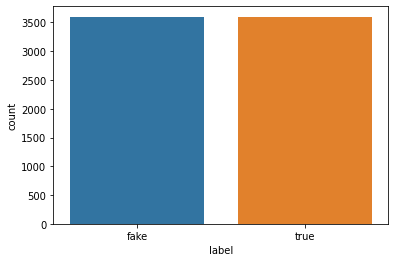

In [8]:
sns.countplot(data.label);

In [ ]:
import math
math.pow(2, 16)

65536.0

In [9]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(data, target_vocab_size=2**16)

AttributeError: ignored